In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Set worling dir & get data
os.chdir('E:\Coding\Python\Earth Data Analytics')

In [2]:
# Import data
data_path = os.path.join("data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                              "usa-boundary-dissolved.shp"))
                                 
state_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                            "usa-states-census-2014.shp"))
                               
pop_places = gpd.read_file(os.path.join(data_path, "global", 
                                        "ne_110m_populated_places_simple", 
                                        "ne_110m_populated_places_simple.shp"))
                                        
ne_roads = gpd.read_file(os.path.join(data_path, "global", 
                                      "ne_10m_roads", "ne_10m_roads.shp"))

,geometry,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER
region,,,,,,,,,,
Midwest,"MULTIPOLYGON Z (((-87.80048 42.49192 0.00000, ...",17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458
Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500
Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551
Southwest,"POLYGON Z ((-94.48587 33.63787 0.00000, -94.41...",48,01779801,0400000US48,48,TX,Texas,00,676601887070,19059877230
West,"MULTIPOLYGON Z (((-104.05325 41.00141 0.00000,...",06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881


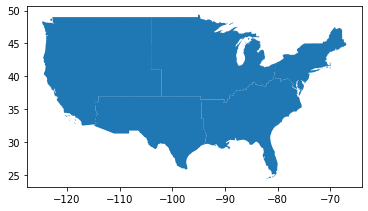

In [6]:
# Simplify the country boundary just a little bit to make this run faster
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

# Clip the roads to the US boundary - this will take about a minute to execute
roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

# Dissolve states by region
regions_agg = state_bound_us.dissolve(by="region")
regions_agg.plot()
regions_agg.head()

In [5]:
# Roads within region
roads_region = gpd.sjoin(roads_cl, 
                         regions_agg, 
                         how="inner", 
                         op='intersects')

# Notice once you have joins the data - you have attributes 
# from the regions_object (i.e. the region) attached to each road feature
roads_region[["featurecla", "index_right", "ALAND"]].head()

D:\Program Files\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3364: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,featurecla,index_right,ALAND
1453,Road,West,403483823181
1434,Road,West,403483823181
1492,Road,West,403483823181
50512,Road,West,403483823181
49677,Road,West,403483823181


In [7]:
# Reproject to Albers for plotting
country_albers = country_bound_us.to_crs({'init': 'epsg:5070'})
roads_albers = roads_region.to_crs({'init': 'epsg:5070'})

D:\Program Files\Python\Python38\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
D:\Program Files\Python\Python38\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


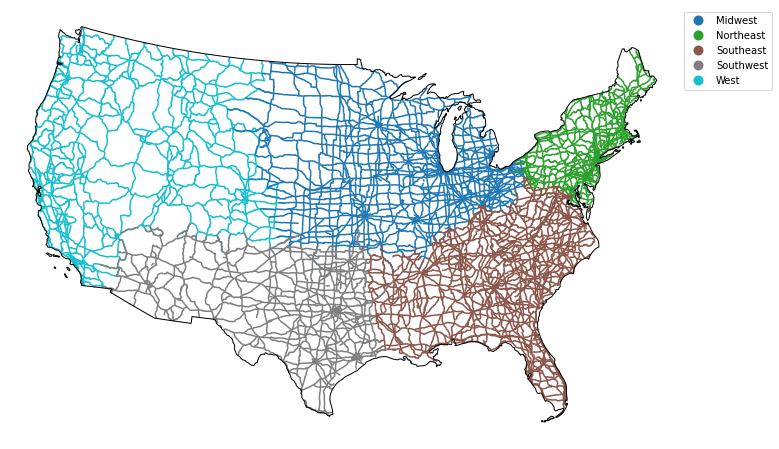

In [8]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

roads_albers.plot(column='index_right',
                  ax=ax,
                  legend=True)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

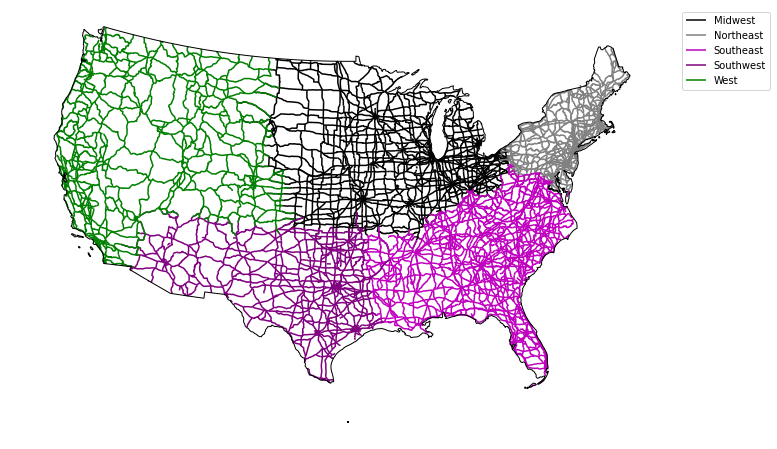

In [10]:
# First, create a dictionary with the attributes of each legend item
road_attrs = {'Midwest': ['black'],
              'Northeast': ['grey'],
              'Southeast': ['m'],
              'Southwest': ['purple'],
              'West': ['green']}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                 ax=ax)
country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

for ctype, data in roads_albers.groupby('index_right'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax)
    
# This approach works to place the legend when you have defined labels
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis('equal')
plt.show()

In [11]:
# Turn off scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Calculate the total length of road 
road_albers_length = roads_albers[['index_right', 'length_km']]

# Sum existing columns
roads_albers.groupby('index_right').sum()

roads_albers['rdlength'] = roads_albers.length
sub = roads_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

,rdlength
index_right,
Midwest,86575020.6373
Northeast,33786036.8608
Southeast,84343077.8904
Southwest,49373104.8209
West,61379830.5534
